# Smoothing particles

In [1]:
# Libraries ----
import sys  # type: ignore
import warnings

import imageio  # type: ignore
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append("../modules")
import plot_clustering as plt_cp  # type: ignore
import plot_smoothing as plt_sp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import smoothing_particles as sp  # type: ignore
import track_particles as tp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

ordering = True
video_name = "4n_0m_4f_230330_2"
n_particles = int(video_name[0])
save_figures = True
x_bounds = [0, 1080]
y_bounds = [60, 1840]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Load tracked data

In [3]:
df_tracked = pd.read_csv(
    "{}/clustered_{}.csv".format(output_path, video_name), low_memory=False
)
df_tracked.head(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,110.841087,61.000000,125.018802,47.000000,NaN,110.841087,61.000000,NaN,110.841087,61.000000,1.315672,10855.0,422.210146,191.098291,0.891706,4,NaN,NaN,NaN,NaN,False,False,False
1,1,0,71.000000,180.000000,75.018802,167.453360,NaN,60.841087,180.036849,NaN,60.841087,180.036849,-0.038240,10855.0,422.210146,191.098291,0.891706,4,NaN,NaN,NaN,NaN,False,False,False
2,2,0,110.841087,361.036849,125.018802,357.453360,NaN,110.841087,361.036849,NaN,110.841087,361.036849,-0.038240,10855.0,422.210146,191.098291,0.891706,4,NaN,NaN,NaN,NaN,False,False,False
3,3,0,1688.654083,946.185121,1688.350248,926.874967,NaN,1688.654083,946.185121,NaN,1688.654083,946.185121,-0.328264,6331.0,284.882246,77.154991,0.962627,4,NaN,NaN,NaN,NaN,False,False,False


In [4]:
df_tracked.tail(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
43228,0,32424,109.132969,52.775956,113.624287,59.256884,NaN,109.132969,52.775956,NaN,109.132969,52.775956,1.170787,549.0,135.037512,61.050870,0.891966,4,3.0,-2.845953,-1.675305,0.015634,False,False,False
43229,1,32424,57.480791,166.665622,62.442537,174.386808,NaN,57.480791,166.665622,NaN,57.480791,166.665622,0.172136,6065.0,265.468800,113.285185,0.904376,4,3.0,0.047430,-0.596129,-0.004786,False,False,False
43230,2,32424,1382.716031,165.754004,1387.550030,170.527763,NaN,1382.716031,165.754004,NaN,1382.716031,165.754004,1.127970,12114.0,232.339862,90.164408,0.921629,4,3.0,0.051337,0.010996,0.000040,False,False,False
43231,3,32424,1677.335598,983.746700,1678.699476,971.550937,NaN,1677.335598,983.746700,NaN,1677.335598,983.746700,-0.413642,5152.0,137.254149,77.491081,0.825378,4,3.0,0.040035,-0.005355,-0.000575,False,False,False


## Swapping mixed IDs

In [5]:
omega_threshold = 20 * np.pi / 180  # Angular velocity per frame (in degrees)
velocity_threshold = 83  # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
delta = 400

arg_list = [
    # VIDEO 1
    [0    , 10000, velocity_threshold, omega_threshold, True],
    [10000, 20000, velocity_threshold, omega_threshold, True],
    [20000, 30000, velocity_threshold, omega_threshold, True],
    [30000, 32428, velocity_threshold, omega_threshold, True]#,
    # [40000, 50000, velocity_threshold, omega_threshold, True],
    # [50000, 60000, velocity_threshold, omega_threshold, True],
    # [60000, 70000, velocity_threshold, omega_threshold, True],
    # [70000, 80000, velocity_threshold, omega_threshold, True],
    # [80000, 90000, velocity_threshold, omega_threshold, True],
    # [90000, 100000, velocity_threshold, omega_threshold, True],
    # [100000, 110000, velocity_threshold, omega_threshold, True],
    # [110000, 120000, velocity_threshold, omega_threshold, True],
    # [120000, 130000, velocity_threshold, omega_threshold, True],
    # [130000, 140000, velocity_threshold, omega_threshold, True],
    # [140000, 150000, velocity_threshold, omega_threshold, True],
    # [150000, 162000, velocity_threshold, omega_threshold, True]
]

df_final = sp.smooth_frames(
    df_tracked=df_tracked,
    arg_list=arg_list,
    order=False,
    log_path=log_path,
    log_filename="log_{}".format(video_name),
    verbose=1,
    tqdm_bar=True
)

df_final.head(8)

Thresholds:
	- Velocity: 83 
	- Angle: 20.0 



100%|█████████████████████████| 4/4 [00:49<00:00, 12.31s/it]


Time: 30000 Chunks 2 Allowed time 30000 Permutation [0 1 2 3]


,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,True,0,chunk_00000_10000,0,0,110.841087,61.000000,125.018802,47.000000,NaN,110.841087,61.000000,NaN,110.841087,61.000000,1.315672,1.315672,10855.0,422.210146,191.098291,0.891706,4,NaN,NaN,NaN,NaN,False,False,False
1,True,0,chunk_00000_10000,1,1,71.000000,180.000000,75.018802,167.453360,NaN,60.841087,180.036849,NaN,60.841087,180.036849,-0.038240,-0.038240,10855.0,422.210146,191.098291,0.891706,4,NaN,NaN,NaN,NaN,False,False,False
2,True,0,chunk_00000_10000,2,2,110.841087,361.036849,125.018802,357.453360,NaN,110.841087,361.036849,NaN,110.841087,361.036849,-0.038240,-0.038240,10855.0,422.210146,191.098291,0.891706,4,NaN,NaN,NaN,NaN,False,False,False
3,True,0,chunk_00000_10000,3,3,1688.654083,946.185121,1688.350248,926.874967,NaN,1688.654083,946.185121,NaN,1688.654083,946.185121,-0.328264,-0.328264,6331.0,284.882246,77.154991,0.962627,4,NaN,NaN,NaN,NaN,False,False,False
4,True,3,chunk_00000_10000,0,0,110.841087,61.000000,125.018802,47.000000,NaN,110.841087,61.000000,NaN,110.841087,61.000000,1.315672,1.315672,10855.0,422.210146,191.098291,0.891706,4,3.0,-4.736952e-15,0.000000,0.0,False,False,False
5,True,3,chunk_00000_10000,1,1,84.410082,179.543535,89.090484,174.551128,NaN,81.023778,179.555819,NaN,81.023778,179.555819,-0.038240,-0.038240,10855.0,422.210146,191.098291,0.891706,4,3.0,4.470027e+00,-0.152155,0.0,False,False,False
6,True,3,chunk_00000_10000,2,2,110.841087,361.036849,125.018802,357.453360,NaN,110.841087,361.036849,NaN,110.841087,361.036849,-0.038240,-0.038240,10855.0,422.210146,191.098291,0.891706,4,3.0,-4.736952e-15,0.000000,0.0,False,False,False
7,True,3,chunk_00000_10000,3,3,1689.472614,944.918401,1689.561211,925.735526,NaN,1689.472614,944.918401,NaN,1689.472614,944.918401,-0.328264,-0.328264,6331.0,284.882246,77.154991,0.962627,4,3.0,2.728437e-01,-0.422240,0.0,False,False,False


In [6]:
df_final.tail(5)

,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
43227,True,32421,chunk_30000_32428,3,3,1677.215492,983.762765,1678.237616,972.161390,NaN,1677.215492,983.762765,NaN,1677.215492,983.762765,-0.411918,-0.411918,5151.0,136.313694,77.556910,0.822366,4,3.0,-0.001337,0.069698,-0.001793,False,False,False
43229,True,32424,chunk_30000_32428,1,0,57.480791,166.665622,62.442537,174.386808,NaN,57.480791,166.665622,NaN,57.480791,166.665622,0.172136,0.172136,6065.0,265.468800,113.285185,0.904376,4,3.0,0.047430,-0.596129,-0.004786,False,False,False
43228,True,32424,chunk_30000_32428,0,1,109.132969,52.775956,113.624287,59.256884,NaN,109.132969,52.775956,NaN,109.132969,52.775956,1.170787,-1.170787,549.0,135.037512,61.050870,0.891966,4,3.0,-2.845953,-1.675305,0.015634,False,False,False
43230,True,32424,chunk_30000_32428,2,2,1382.716031,165.754004,1387.550030,170.527763,NaN,1382.716031,165.754004,NaN,1382.716031,165.754004,1.127970,-1.127970,12114.0,232.339862,90.164408,0.921629,4,3.0,0.051337,0.010996,0.000040,False,False,False
43231,True,32424,chunk_30000_32428,3,3,1677.335598,983.746700,1678.699476,971.550937,NaN,1677.335598,983.746700,NaN,1677.335598,983.746700,-0.413642,-0.413642,5152.0,137.254149,77.491081,0.825378,4,3.0,0.040035,-0.005355,-0.000575,False,False,False


## Interpolation over not allowed frames

In [7]:
if ordering:
    df_full = df_final.copy().sort_values(["time", "permuted_id"])
    for id_ in range(len(df_full["permuted_id"].unique())):
        mask = df_full.loc[:, "permuted_id"] == df_full["permuted_id"].unique()[id_]
        df_full[mask] = df_full[mask].interpolate(method="linear")

In [8]:
if ordering:
    cols = [
        "id",
        "permuted_id",
        "time",
        "position_x",
        "position_y",
        "weighted_x",
        "weighted_y",
        "darkest_v",
        "darkest_x",
        "darkest_y",
        "lightest_v",
        "lightest_x",
        "lightest_y",
        "orientation",
        "corrected_orientation",
        "area",
        "axis_major",
        "axis_minor",
        "eccentricity",
    ]
    df_temp = df_full[cols]
    df_temp.to_csv(
        "{}/interpolated_{}.csv".format(output_path, video_name), index=False
    )
    df_temp

Thresholds:
	- Velocity: 24.457645528866223 
	- Angle: 21.700845635735266 



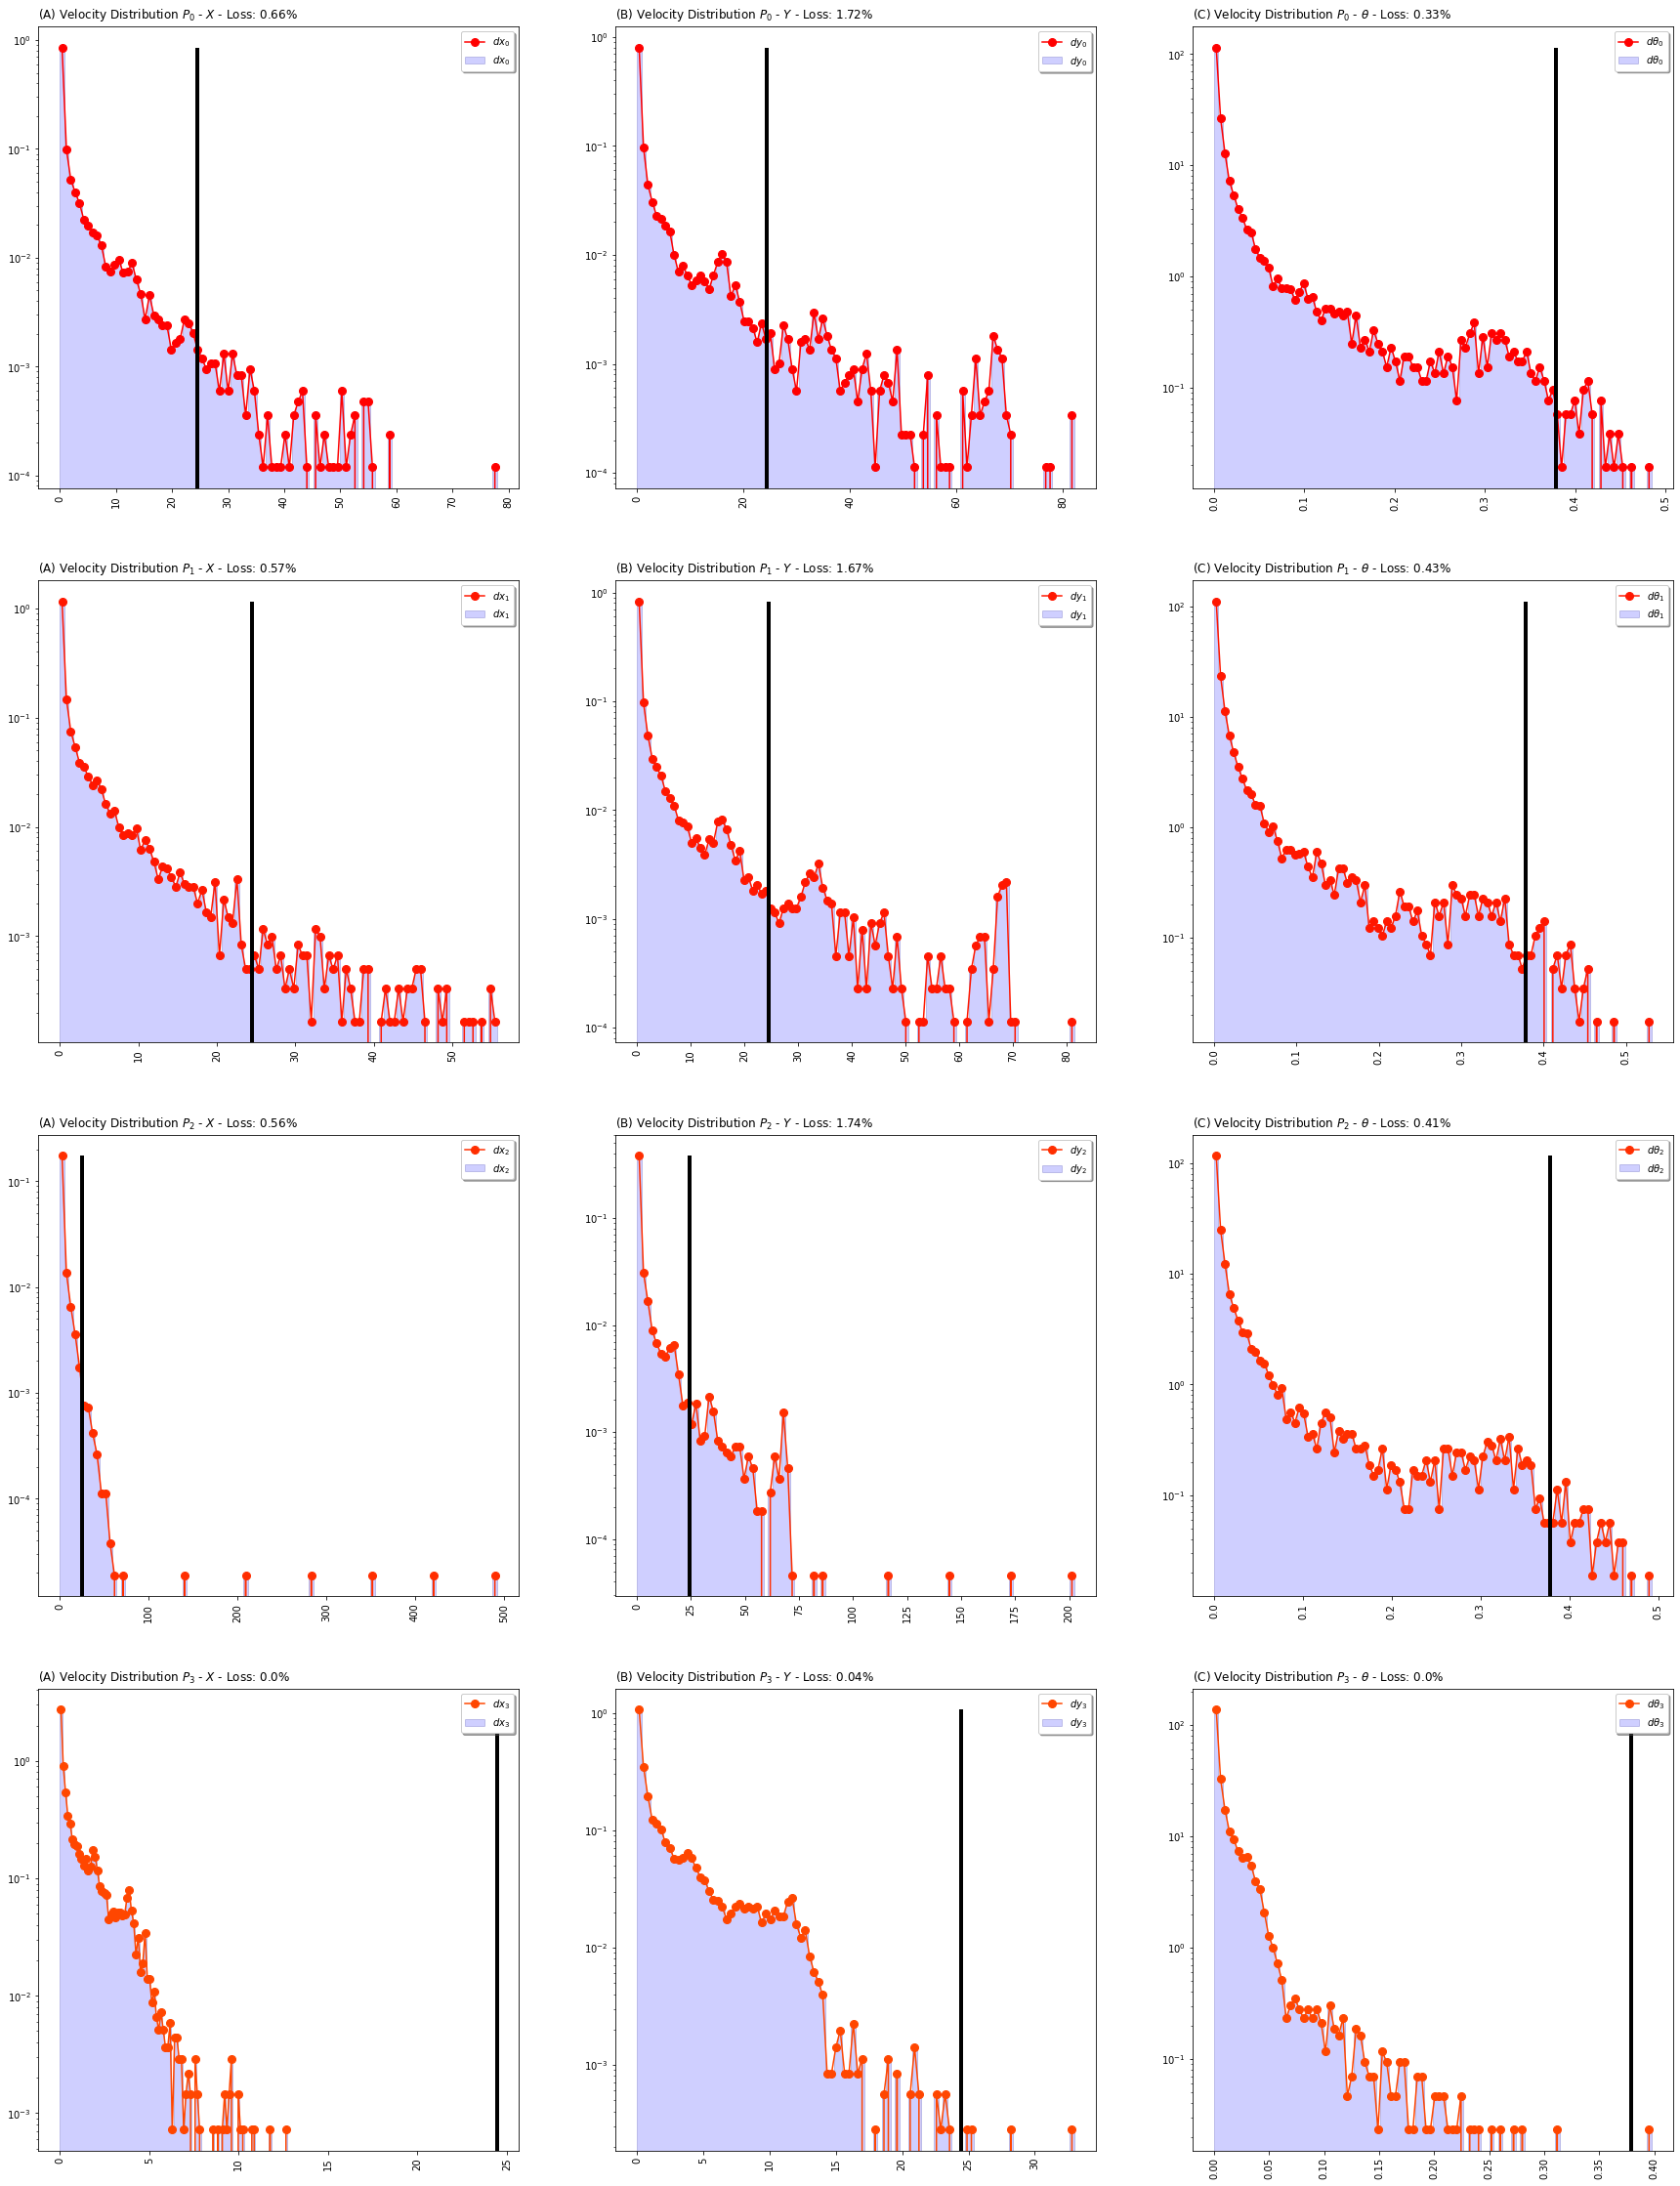

In [9]:
if ordering:
    bins = 100
    width = 10
    fancy_legend = True
    omega_threshold = (
        df_full["velocity_orientation"].abs().quantile(0.9965)
    )  # Angular velocity per frame
    velocity_threshold = (
        df_full["velocity_x"].abs().quantile(0.9901)
    )  # Velocity per frame limited with half average size of particle
    print(
        "Thresholds:\n\t- Velocity:",
        velocity_threshold,
        "\n\t- Angle:",
        omega_threshold * 180 / np.pi,
        "\n",
    )

    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_cp.plot_velocities_distribution(
        df_tracked=df_smooth,
        bins=bins,
        velocity_threshold=velocity_threshold,
        omega_threshold=omega_threshold,
        width=width,
        fancy_legend=fancy_legend,
    )

Original


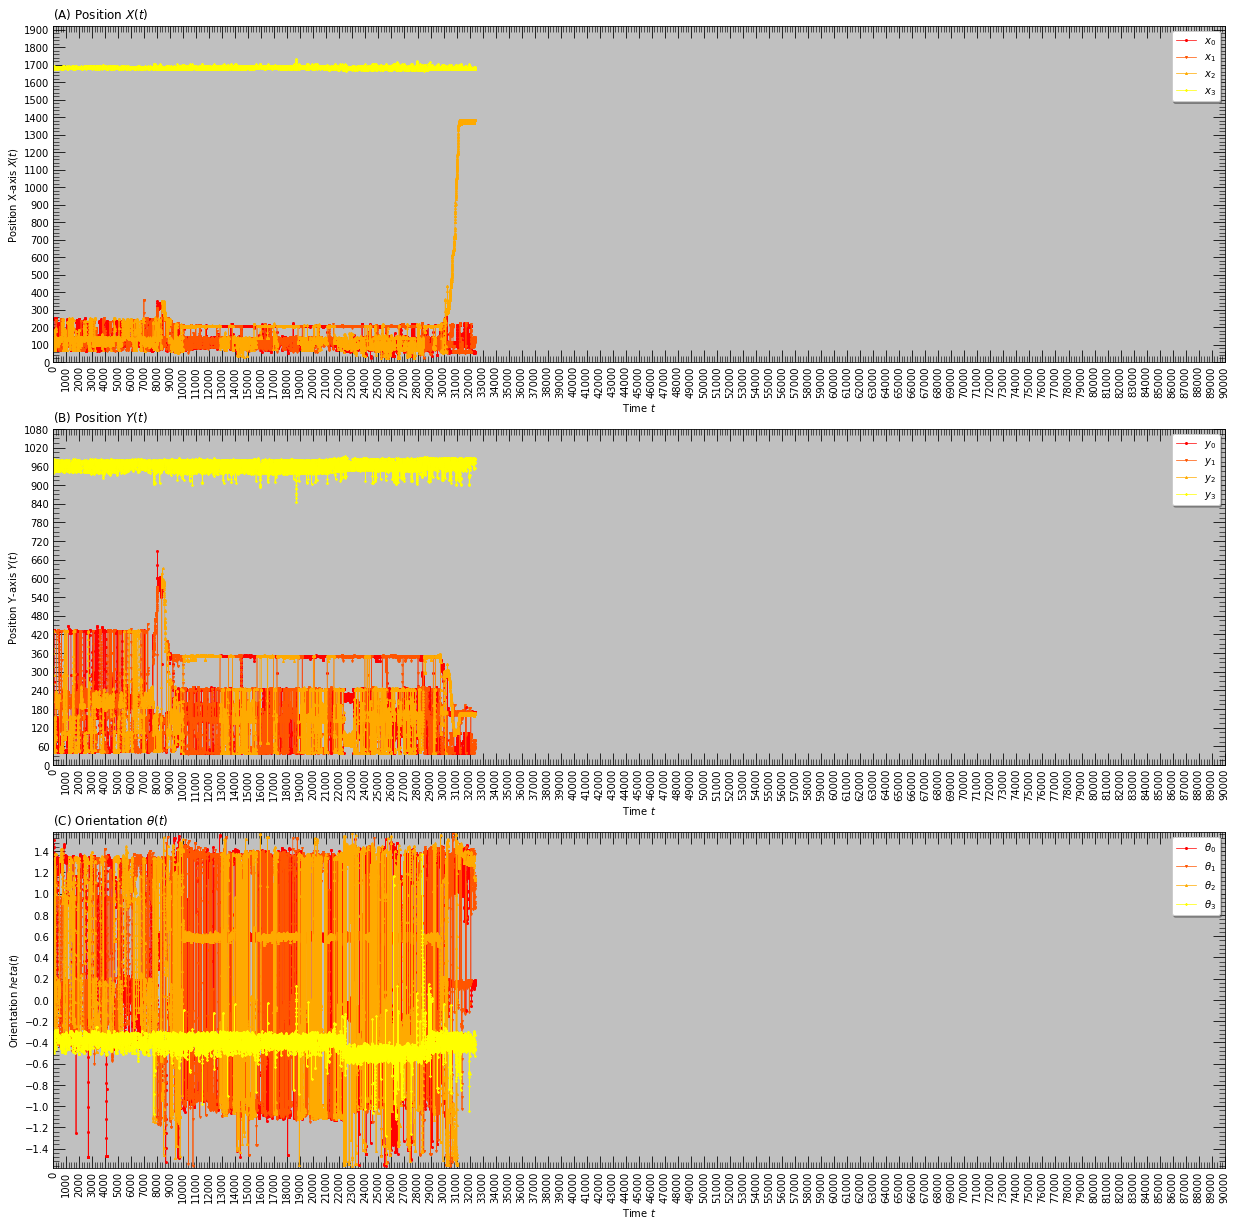

Corrected Orientation


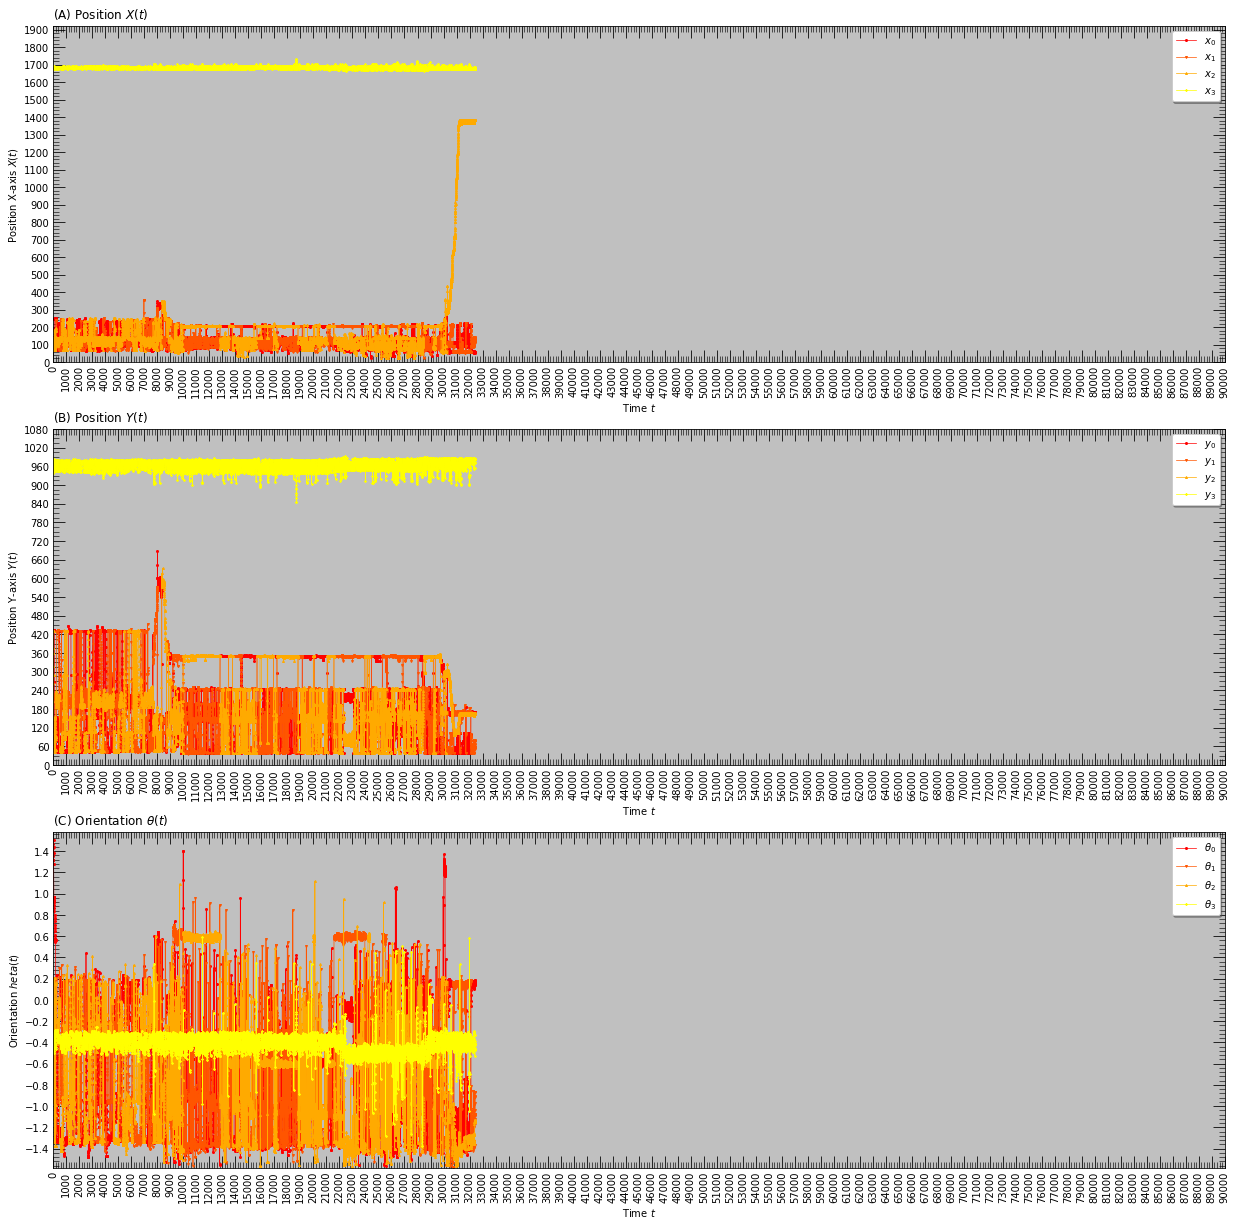

In [10]:
if ordering:
    width = 21
    n_x_breaks = 100
    n_y_breaks = 20
    t0, tf = 0, 90000  # 22200, 24300
    t0_, tf_ = 0, 90000  # 22200, 24300
    t_bounds = [t0_, tf_]
    p_bounds = [[0, 1920], [0, 1080], [-1.58, 1.58]]
    fancy_legend = True

    print("Original")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    velocity_threshold = (
        df_full["velocity_x"].abs().quantile(0.9701)
    )  # Velocity per frame limited with half average size of particle
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[
            (
                (df_smooth["velocity_x"] <= velocity_threshold)
                & (df_smooth["velocity_y"] <= velocity_threshold)
            )
        ],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend,
    )

    print("Corrected Orientation")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[
            (
                (df_smooth["velocity_x"] <= velocity_threshold)
                & (df_smooth["velocity_y"] <= velocity_threshold)
            )
        ],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend,
    )